In [72]:
# --- Preamble --- 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qgrid
import re
from IPython.display import HTML
from pytz import timezone # timezone information 
from pivottablejs import pivot_ui
import datetime
from datetime import time
from datetime import timedelta

# - Astro-packages
import astropy
import astropy.units as u
import astropy.coordinates as coord
import astropy.table
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun, get_moon #- for tranformations, takes ref. from simbad.
from astropy.time import Time
from astropy.table import QTable, Table
from astroplan import (observability_table,FixedTarget, Observer, AltitudeConstraint, AtNightConstraint, MoonSeparationConstraint, SunSeparationConstraint)
from astroplan.utils import time_grid_from_range
from astroquery.simbad import Simbad 



#--- plot parameters --- 
plt.rcParams["figure.figsize"] = (15,10)
plt.rc('font', family = 'serif', serif = 'cmr10') 
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 30

hfont = {'fontname':'Helvetica'}

### Intial Parameter Setup

In [73]:
# --- Station Parameter's --- 

ILOFAR = Observer(name = 'I-LOFAR',
               location = EarthLocation(lat = 53.09469*u.deg, lon = -7.92153*u.deg, height = 75*u.m),
               #timezone = timezone('Europe/Dublin'),
               description = "I-LOFAR Station in Birr, Co. Offaly, Ireland")

ONSULA = Observer(name = 'LOFAR-SE',
               location = EarthLocation(lat = 57.39885*u.deg, lon = 11.93029*u.deg, height = 18*u.m),
               #timezone = timezone('Europe/Stockholm'),
               description = "LOFAR-SE Station in Onsula, Sweden")

In [80]:
def setup(start_time, end_time, alt_const_min, alt_const_max, sun_sep, granulation, observatory, file_location, distance_calculator):
    """
    ---
    SETUP

    Uses below listed parameter's to constrain targets in a specific window from a masterlist provided by TESS. The constraint is placed upon the targets by astroplan. 
    A .csv with avalible targets for both targets are also written to disk for book-keeping purposes.  

    Output: df - dataframe with constrainted targets. Easy to manpulate and write to .csv
            targets - List of constrained targets in the astropy SkyCoord format. 
            time_s -  String containing observation window start-time 
            common_targets - table used for later cross-reference (not needed)
            table - astroTable used for use with other astropy/astroplan modules (not needed)
    ---

    start_time - start of observation time, format: 'YYYY-MM-DD HH:MM'
    end_time -  end of observation time, format: 'YYYY-MM-DD HH:MM'.
    alt_const_min - min alt in degrees that station can observe. 
    alt_const_max - max alt in degrees that station can observe. 
    sun_sep - min seperation in degrees of Sun from desired target. 
    granulation - The time divisions table will be produced at, the value is a factor of one hour. i.e. 0.25 ~ 15 mins  
    file_location - location of .csv in format, |Name|RA|DEC|
    distance_calculator - When == True will index targets through Simbad to find distance in pc. Accuracy of this indexing is unreliable at best. 
    """
    # --- Timerange --- 
    time_range = Time([start_time, end_time]) # - window of obervation. 
    print(time_range)
    time_s = re.sub('\W+','', start_time )

    # --- Station Constraints --- 
    constraints = [AltitudeConstraint(alt_const_min*u.deg, alt_const_max*u.deg), SunSeparationConstraint(min = sun_sep * u.deg)] # - Constraints based on alt and Sun constraints. (This can be easily and further expanded if needed.)

    # --- Target loading and intial filtering --- 
    data_main = pd.read_csv(file_location) # - loading data from .csv 
    previously_observed_targets = pd.read_csv('data\observed_targets_masterlist.csv')
    previously_observed_targets_names = previously_observed_targets['Name'].astype(str).values.tolist() # - writing previously observed targets to strings 

    filtered_ILOFAR = data_main[data_main['DEC'] > -7] ; filtered_Onsula = data_main[data_main['DEC'] > -3] # - filtering based on what both I-LOFAR and LOFAR-SE stations have in their respective field of view. 
    common_targets = filtered_ILOFAR.merge(filtered_Onsula, how = 'inner' ,indicator=False) # - merging the two data frames for common entries. 

    # --- Printing information about common targets. --- 
    print('Number of objects that do not meet the criteria of both stations:', len(data_main['Name']) - len(common_targets))    
    print('Number of previously observed targets:', len(previously_observed_targets))

    # --- Removing previously observed entries --- 
    
    for i in range(len(previously_observed_targets)):     
        common_targets = common_targets[common_targets.Name != previously_observed_targets_names[i]] # - removing previously observed targets based on the defined list of strings (target names)
    
    print('Number of objects avalible for observation:',  len(common_targets))
    

    target_table = QTable.from_pandas(common_targets) # - converting to astro-table for use in astroplan 
    targets = [FixedTarget(coord = SkyCoord(ra = ra*u.deg, dec = dec*u.deg), name = name) for name, ra, dec in target_table] # - converting into FixedTarget SkyCoords for values in the previous table. 

    table = observability_table(constraints, observatory, targets, time_range = time_range, time_grid_resolution = granulation * u.hour) # - generating observing table. 
    # print(table)

    df = table.to_pandas() # - conversion to dataframe 
    df.sort_values(by = 'fraction of time observable', ascending = False, inplace = True) # - sorting based on name 
    df.to_csv('data/target-lists/stations/%s/%s-Targets-%s.csv' % (str(observatory.name), str(observatory.name), time_s[2:8]), header = True, index  = False) # - saving to .csv 

    # --- distance calculation
    
    if distance_calculator == True: 
        Simbad.add_votable_fields('typed_id', 'distance')
        result = Simbad.query_objects(df['target name'])
        df['Distance (pc)'] = result['Distance_distance']

    return df, targets, time_s, common_targets, table

In [99]:
%%capture

ILOFAR_targets = []
LOFARSE_targets = []

# --- Computing Dataframes --- 
ILOFAR_targets = setup('2021-07-14 08:00', '2021-07-14 12:00', 43.09469, 63.09472, 20, 0.016, ILOFAR, 'data/Simultaneous_SETI_TESS_targets_170621.csv', True)
LOFARSE_targets = setup('2021-07-14 10:00', '2021-07-14 13:00', 47.39305555256, 67.39305555256, 20,  0.016, ONSULA, 'data/Simultaneous_SETI_TESS_targets_170621.csv', False)

In [97]:
fraction_of_ot = 0
combined_targets_dataframe = []

# --- Organising Dataframes --- 
combined_targets_dataframe = pd.merge(ILOFAR_targets[0], LOFARSE_targets[0], on = "target name") # -- merges on title column 

combined_targets_dataframe = combined_targets_dataframe.rename(columns={"ever observable_x": "Ever Observable(I)", "ever observable_y": "Ever Observable(SE)", "always observable_x" : "Always Observable(I)", "always observable_y" : "Always Observable(SE)", "fraction of time observable_x":"Fraction of observable time (I)", "fraction of time observable_y":"Fraction of observable time (SE)", "target name": "Name"}) # -- renaming cols. 

combined_targets_dataframe = combined_targets_dataframe[combined_targets_dataframe['Ever Observable(I)'] == True]; combined_targets_dataframe = combined_targets_dataframe[combined_targets_dataframe['Ever Observable(SE)'] == True] # -- removing targets that can't be observed during the window. 

combined_targets_dataframe = combined_targets_dataframe[combined_targets_dataframe['Fraction of observable time (I)'] > fraction_of_ot];  combined_targets_dataframe = combined_targets_dataframe[combined_targets_dataframe['Fraction of observable time (SE)'] > fraction_of_ot] 

combined_targets_dataframe = pd.merge(combined_targets_dataframe, LOFARSE_targets[3], on = "Name") # - merges on target name. 
combined_targets_dataframe.sort_values(by = 'RA', ascending = True, inplace = True)


combined_targets_dataframe = combined_targets_dataframe[['Name', 'RA', 'DEC', 'Distance (pc)', 'Ever Observable(I)', 'Always Observable(I)', 'Ever Observable(SE)', 'Always Observable(SE)', 'Fraction of observable time (I)' , 'Fraction of observable time (SE)']]

print('Number of possible targets:', len(combined_targets_dataframe))


# --- Saving .csv ---
combined_targets_dataframe.to_csv('data/target-lists/combined/Combined-Targets-%s.csv' % (ILOFAR_targets[2][2:8]), header = True, index  = False)

Number of possible targets: 453


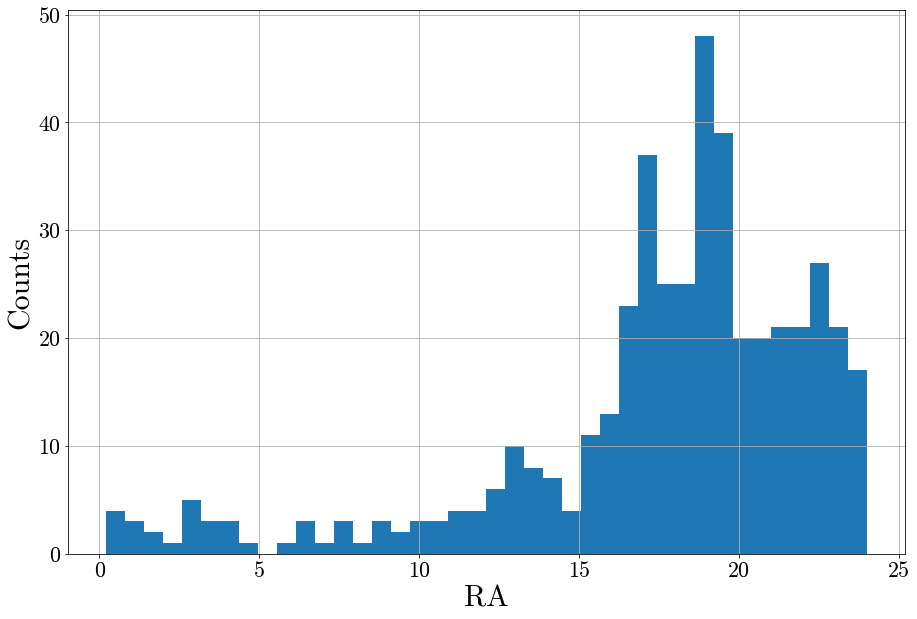

In [98]:
plt.hist(combined_targets_dataframe['RA'], density = False, bins = 40)  
plt.ylabel('Counts')
plt.xlabel('RA')
plt.grid()

### Plot of grid Observation times

In [25]:
target_table = ILOFAR_targets[1]
target_table[1].name



def observation_grid(start_time, end_time, target_index, observatory, alt_const_min, alt_const_max, sun_sep, moon_sep):

    target = target_table[target_index]
    constraints = [AltitudeConstraint(alt_const_min*u.deg, alt_const_max*u.deg), SunSeparationConstraint(min = sun_sep * u.deg), MoonSeparationConstraint(min = moon_sep * u.deg)] 

    # Define range of times to observe between
    start_time = Time(start_time)
    end_time = Time(end_time)
    time_resolution = 0.2 * u.hour

    # Create grid of times from ``start_time`` to ``end_time``
    # with resolution ``time_resolution``
    time_grid = time_grid_from_range([start_time, end_time],
                                    time_resolution=time_resolution)

    observability_grid = np.zeros((len(constraints), len(time_grid)))

    for i, constraint in enumerate(constraints):
        # Evaluate each constraint
        observability_grid[i, :] = constraint(observatory, target, times=time_grid)

    # Create plot showing observability of the target:

    extent = [-0.5, -0.5+len(time_grid), -0.5, 2.5]

    fig, ax = plt.subplots()
    ax.imshow(observability_grid, extent=extent)

    ax.set_yticks(range(0, 3))
    ax.set_yticklabels([c.__class__.__name__ for c in constraints])

    ax.set_xticks(range(len(time_grid)))
    ax.set_xticklabels([t.datetime.strftime("%H:%M") for t in time_grid])

    ax.set_xticks(np.arange(extent[0], extent[1]), minor=True)
    ax.set_yticks(np.arange(extent[2], extent[3]), minor=True)

    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    ax.tick_params(axis='x', which='minor', bottom='off')
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    ax.tick_params(axis='y', which='minor', left='off')
    # ax.set_xlabel('Time on {0} UTC+1'.format(time_grid[0].datetime.date()))
    ax.set_xlabel(target.name)
    fig.subplots_adjust(left=0.35, right=0.9, top=0.9, bottom=0.1)
    plt.show()

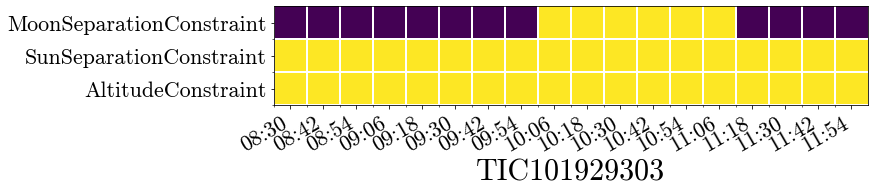

In [26]:
observation_grid('2021-06-30 08:30:01', '2021-06-30 12:00:01', 0, ILOFAR, 47, 58, 20, 0)

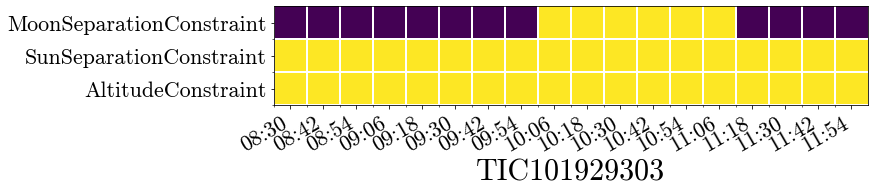

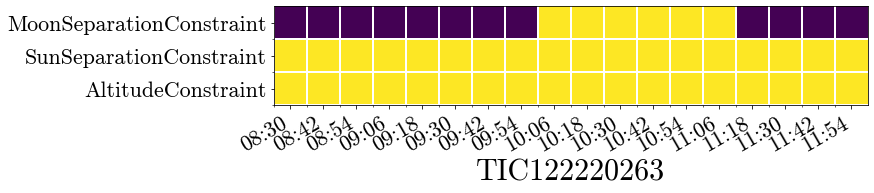

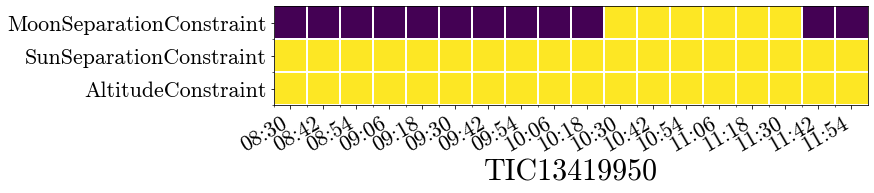

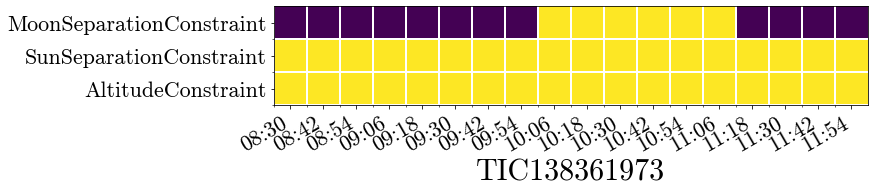

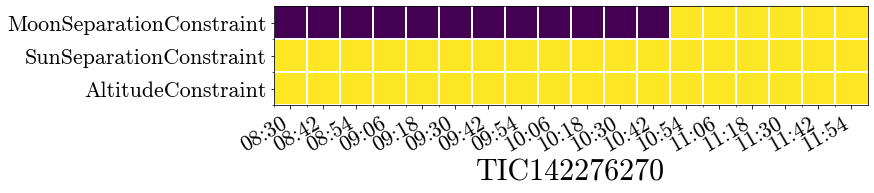

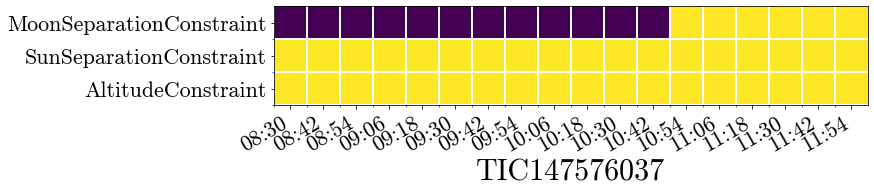

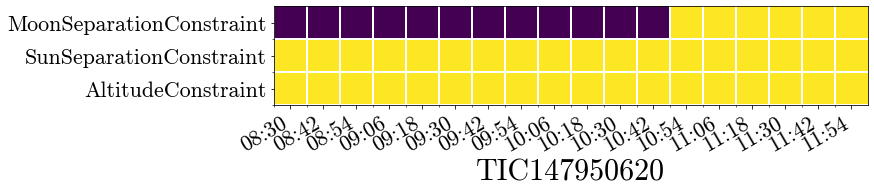

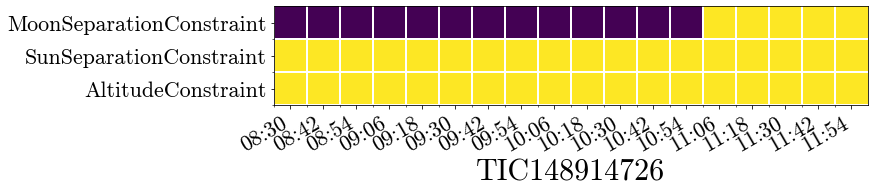

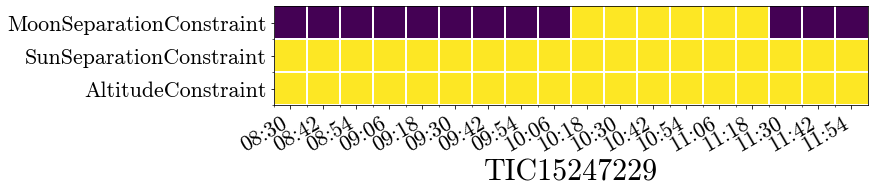

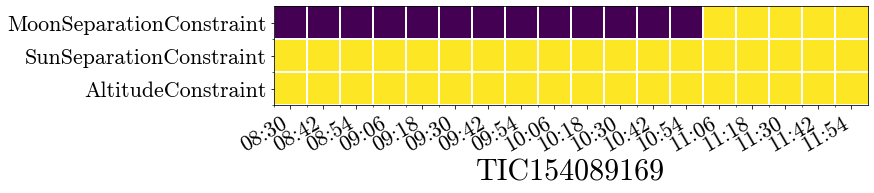

In [27]:
for i in range(0, 10):
    observation_grid('2021-06-30 08:30:01', '2021-06-30 12:00:01', i, ILOFAR, 47, 58, 20, 0)